# AOMA with reference based Cov-SSI from STRID package

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy import signal
import dataloader_halogaland.dataloader as dl
from dataloader_halogaland.plot import welch_plot, stabilization_diagram
import os
import koma.oma, koma.plot
import koma.clustering
import strid
from time import time

/Users/emilneby/miniforge3/envs/master/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Load data from hdf5 file format

In [2]:
analysis_length = 30 #minutes
cutoff_frequency = 1 #Hz
bridgedeck_only = True

loader= dl.HDF5_dataloader(os.getcwd()+'/../../../../../../../Volumes/LaCie/Halogaland_sixth_try.hdf5', bridgedeck_only=bridgedeck_only)

Available accelerometers: ['A03-1', 'A03-2', 'A04-1', 'A04-2', 'A05-1', 'A05-2', 'A06-1', 'A06-2', 'A07-1', 'A07-2', 'A08-1', 'A08-2', 'A09-1', 'A09-2', 'A10-1', 'A10-2']


In [4]:
acc = loader.load_all_acceleration_data(loader.periods[12], preprosess=True, cutoff_frequency=cutoff_frequency, filter_order=10)
print(len(acc[:,0]))
acc = acc[:2*cutoff_frequency*60*analysis_length,:]
acc = acc.transpose()
print(acc.shape)

X-vector shape: (57600, 16)
Y-vector shape: (57600, 16)
Z-vector shape: (57600, 16)
Total-vector shape: (57600, 48)
57600
(48, 3600)


### Reference based Cov-SSI from strid-package

In [28]:
#Parameters
i = 50 #number of block rows
s = 6
fs = 2
orders = np.arange(2, 80+2, 2) #orders to perform system identification for
#stabcrit = {'freq': 0.05, 'damping': 0.1, 'mac': 0.1} # Default

In [29]:
#Indices for reference channels:
"""
0-21 are channels for x-dirdction, we discard them due to assumed little excitation.
Indices [1,3,5,7,11,13,17,19] will give channels for one section of the bridge excluding towers and hangers. Add 22 and 44 respectively to get y and z direction respectively.
"""

"""
When bridge deck only channels are included, there are 16 channels in total.
Indices [0, 2, 4, 6, 8, 10, 12, 14]
"""

if bridgedeck_only:
    ix_references_y = (np.array([0, 2, 4, 6, 8, 10, 12, 14])+16)
    ix_references_z = (np.array([0, 2, 4, 6, 8, 10, 12, 14])+32)
    ix_references = np.concatenate((ix_references_y, ix_references_z)).tolist()
else:
    ix_references_y = (np.array([1,3,5,7,11,13,17,19])+22)
    ix_references_z = (np.array([1,3,5,7,11,13,17,19])+44)
    ix_references = np.concatenate((ix_references_y, ix_references_z)).tolist()



print((ix_references))

[16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46]


In [30]:
ssid = strid.CovarianceDrivenStochasticSID(acc, fs, ix_references)

In [31]:
#Perform system identification
t0 = time()
modes = {}
for order in orders:
    A, C, G, R0 = ssid.perform(order, i)
    modes[order] = strid.Mode.find_modes_from_ss(A, C, ssid.fs)

t1 = time()
print("Execution time = " + str(t1-t0))

Execution time = 2.0768020153045654


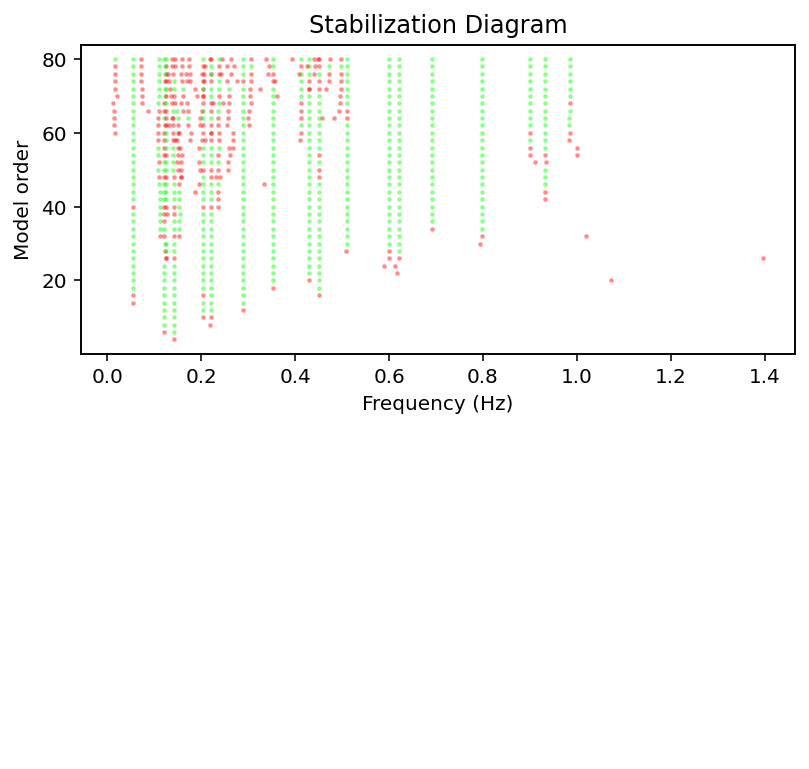

In [32]:
#Filtering routine, pick "stable" modes
stabdiag = strid.StabilizationDiagram()
stabdiag.plot(modes)
modes = stabdiag.filter_modes(modes)

In [33]:
#Sorting routine, from dictionary based modes into corresponding list with features
orders = []
lambdas = []
phis = []

for order in modes.keys():
    modes_in_order = modes[order]
    for mode in modes_in_order:
        orders.append(order)
        lambdas.append(mode.eigenvalue)
        phis.append(mode.eigenvector)

orders = np.array(orders)
lambdas = np.array(lambdas)
phis = np.array(phis).transpose()

### HDBSCAN to cluster poles from KOMA package

In [34]:
#Pole clustering
pole_clusterer = koma.clustering.PoleClusterer(lambdas, phis, orders, min_cluster_size=10, min_samples=10, scaling={'mac':1.0, 'lambda_real':0.7, 'lambda_imag': 0.5})
prob_threshold = 0.5   #probability of pole to belong to cluster, based on estimated "probability" density function
args = pole_clusterer.postprocess(prob_threshold=prob_threshold, normalize_and_maxreal=True)

xi_auto, omega_n_auto, phi_auto, order_auto, probs_auto, ixs_auto = koma.clustering.group_clusters(*args)

#plot_koma.plot_stab_from_KOMA(np.array(omega_n_auto)/2/np.pi, order_auto).savefig("results/realization_" + str(j) + ".jpg")

xi_mean = np.array([np.mean(xi_i) for xi_i in xi_auto])
fn_mean = np.array([np.mean(om_i) for om_i in omega_n_auto])/2/np.pi

xi_std = np.array([np.std(xi_i) for xi_i in xi_auto])
fn_std = np.array([np.std(om_i) for om_i in omega_n_auto])/2/np.pi

### Create stabilization diagram

/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_24663/18250576.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc.transpose(), fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambdas)/2/np.pi, all_orders=orders)


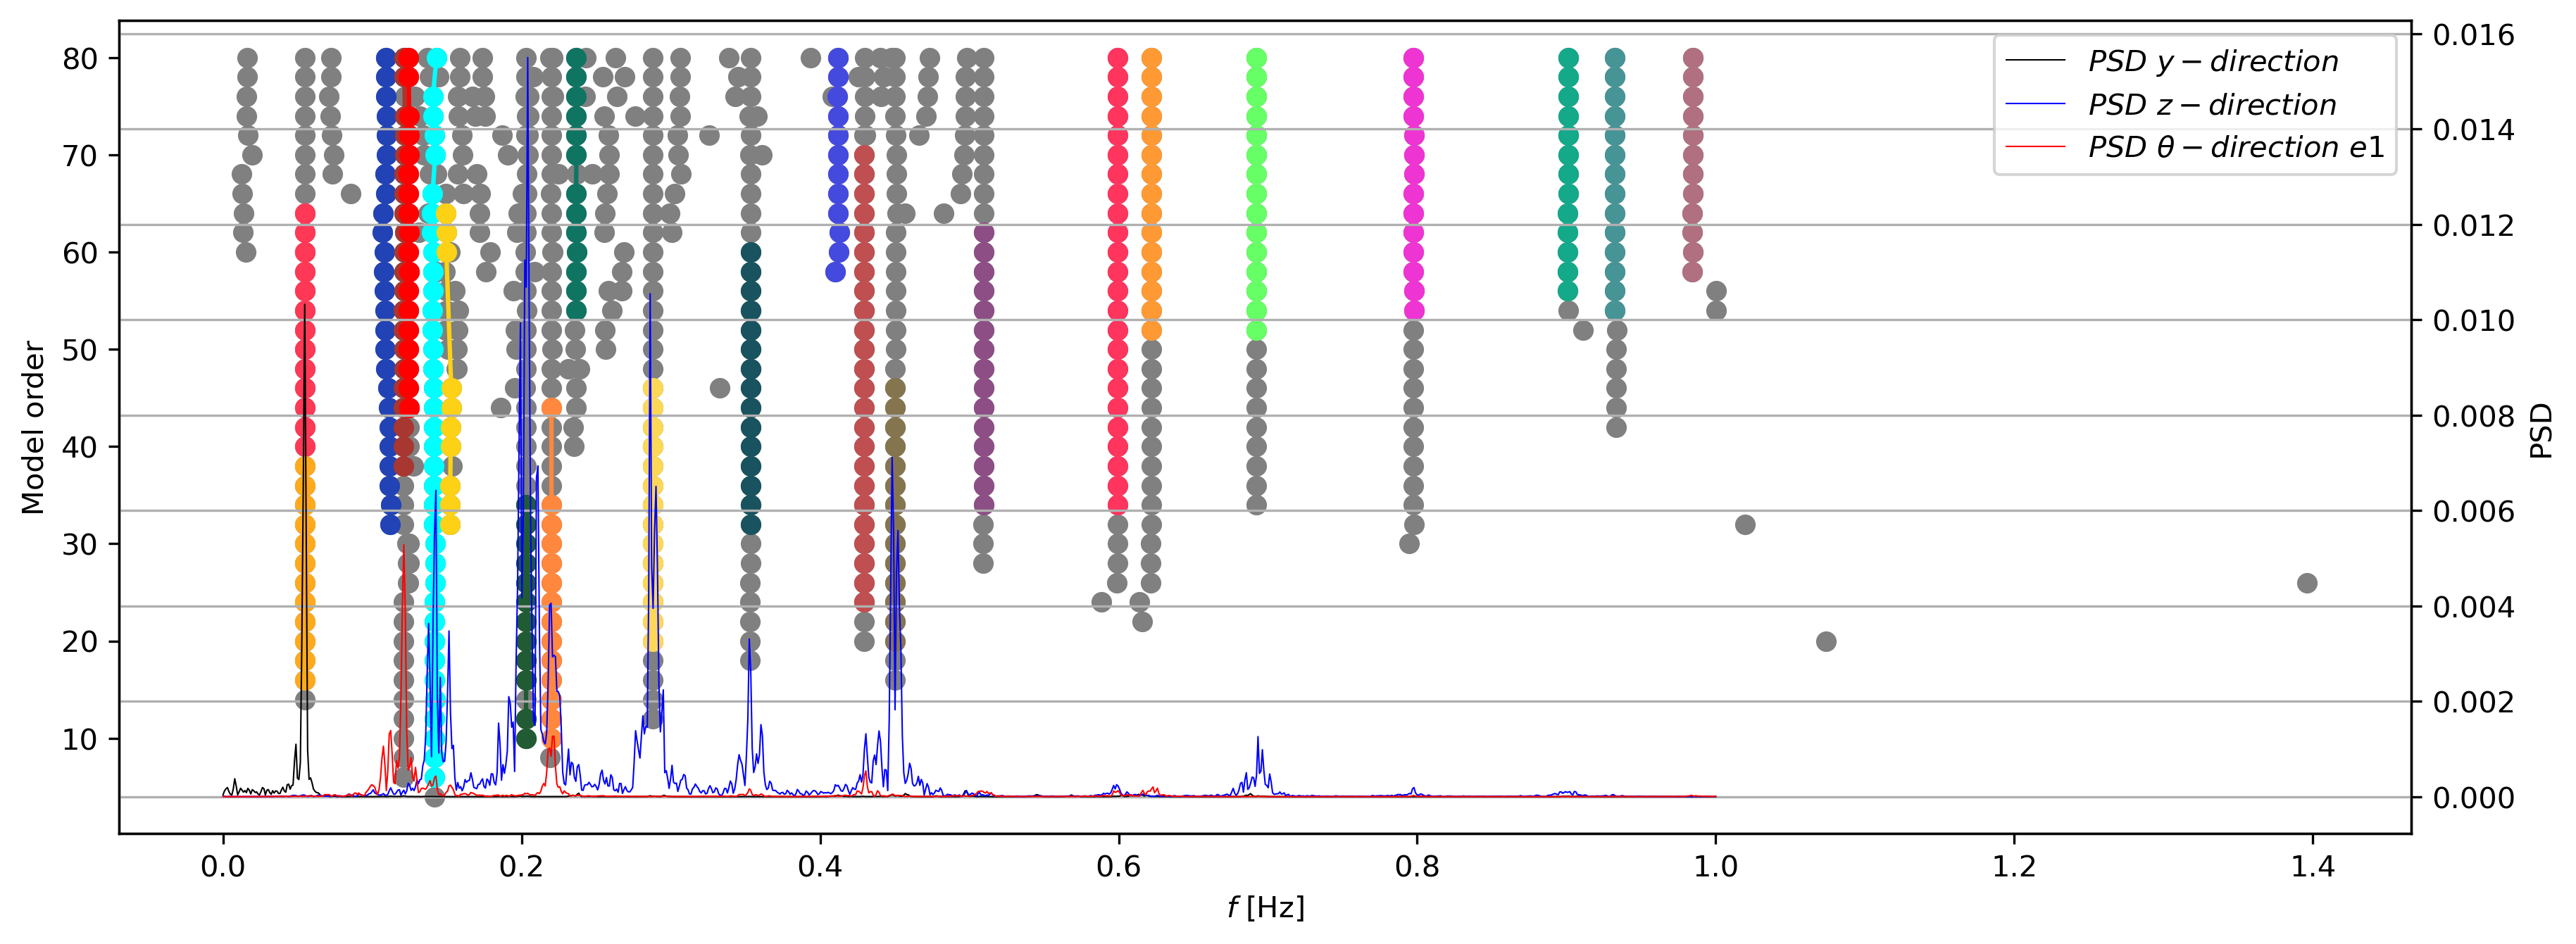

In [35]:
stab_diag = stabilization_diagram(acc.transpose(), fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambdas)/2/np.pi, all_orders=orders)
plt.savefig("stabilization_diagram.jpg")

In [36]:
# Print table
import pandas as pd
res_data = np.vstack([fn_mean, 100*xi_mean]).T
results = pd.DataFrame(res_data, columns=['$f_n$ [Hz]', r'$\xi$ [%]'])
results

,$f_n$ [Hz],$\xi$ [%]
0,0.054714,1.400218
1,0.054865,1.536883
2,0.109548,5.661069
3,0.121276,1.619670
4,0.124325,1.933563
5,0.141283,3.328560
6,0.151570,2.372728
7,0.202967,2.086278
8,0.220002,1.210126
9,0.236631,0.931581
